In [11]:
#files=glob.glob('*.png')
#fname=files[3]
fname="slide1.png"

In [12]:
class_names=["Fat", "Muscular", "Vessle", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]
nclasses=len(class_names)

In [13]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal
import argparse
from torch import nn
from torchsummary import summary

from skimage import color 

from albumentations import *
from albumentations.pytorch import ToTensor

import sklearn.feature_extraction.image

import matplotlib.cm

import torch

from torchvision.models import DenseNet

from tqdm.autonotebook import tqdm

from  skimage.color import rgb2gray


import glob

import dill as pickle

from skimage.color import rgb2gray, rgb2hed

from skimage.measure import * 
from skimage.filters import *
from skimage.morphology import *


In [14]:
def blend2Images(img, mask):
    if (img.ndim == 3):
        img = color.rgb2gray(img)
    if (mask.ndim == 3):
        mask = color.rgb2gray(mask)
    img = img[:, :, None] * 1.0  # can't use boolean
    mask = mask[:, :, None] * 1.0
    out = np.concatenate((mask, img, mask), 2)
    return out

In [15]:


patch_size=64
batch_size=128 #should be a power of 2

cmap= matplotlib.cm.tab10


In [16]:
import torch
device = torch.device('cuda')
checkpoint = torch.load("./trg_single_best_model.pth", map_location = device)

In [17]:
class SmallNetwork(nn.Module):
    def __init__(self):
        super(SmallNetwork,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, padding = 1),
            nn.ReLU(True),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 6, kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(6),
            nn.Conv2d(6,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8)
        )


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        

        self.final= nn.Sequential(
            nn.Linear(8, 16), #--- add dropout
            nn.ReLU(True),
            nn.BatchNorm1d(16),
            nn.Linear(16, 16),
            nn.ReLU(True),
            nn.Linear(16, nclasses),
        )
                          

        
    def forward(self,x):
        x = self.encoder(x)
        #x = self.decoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x , 1)
        x = self.final(x)
        return x

In [18]:
device = torch.device('cuda')
model = SmallNetwork().to(device)
model.load_state_dict(checkpoint["model_dict"])

summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 64, 64]             168
              ReLU-2            [-1, 6, 64, 64]               0
       BatchNorm2d-3            [-1, 6, 64, 64]              12
            Conv2d-4            [-1, 6, 62, 62]             330
              ReLU-5            [-1, 6, 62, 62]               0
       BatchNorm2d-6            [-1, 6, 62, 62]              12
            Conv2d-7            [-1, 8, 30, 30]             440
              ReLU-8            [-1, 8, 30, 30]               0
       BatchNorm2d-9            [-1, 8, 30, 30]              16
           Conv2d-10            [-1, 8, 14, 14]             584
             ReLU-11            [-1, 8, 14, 14]               0
      BatchNorm2d-12            [-1, 8, 14, 14]              16
           Conv2d-13              [-1, 8, 6, 6]             584
             ReLU-14              [-1, 

In [19]:
def divide_batch(l, n): 
    for i in range(0, l.shape[0], n):  
        yield l[i:i + n,::] 

In [20]:
resize=1
img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(int(img.shape[1]*resize),int(img.shape[0]*resize)))
img=np.pad(img,[(100,100),(100,100),(0,0)],'constant',constant_values=255)



hed=rgb2hed(img)
mask=hed[:,:,0]>-.8
mask=remove_small_objects(mask,150)

In [21]:
mask[img.sum(axis=2)<100]=0

mask[img.sum(axis=2)>700]=0

mask[0:patch_size,:]=0;
mask[:,0:patch_size]=0;

mask[:,-patch_size-1:]=0
mask[-patch_size-1:,:]=0

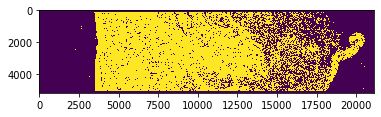

In [22]:
plt.imshow(mask)

In [33]:
def random_subset(a, b, nitems):
    assert len(a) == len(b)
    idx = np.random.randint(0,len(a),nitems)
    return a[idx], b[idx]

In [37]:
max_number_samples=50000
[rs,cs]=mask.nonzero()
[rs,cs]=random_subset(rs,cs,max_number_samples)

centers = [(r,c) for r,c in zip(rs,cs)]

# rps=regionprops(label(mask))

# centers=[rp.centroid for rp in rps]
# centers=np.round(np.asarray(centers))

npatches=len(centers)
#output = np.zeros((npatches,3,patch_size//patch_size,patch_size//patch_size))
arr_out = np.zeros((npatches,3,patch_size,patch_size))

In [38]:
img_transform = Compose([
#        Normalize(mean=(140, 91, 186), std=(51,57,27), max_pixel_value=1),
       ToTensor()
    ])

In [40]:
rs=[]
cs=[]
for i, (r,c) in tqdm(enumerate(centers)):
    r=int(round(r))
    c=int(round(c))
    rs.append(r)
    cs.append(c)

    patch=img[r-patch_size//2:r+patch_size//2,c-patch_size//2:c+patch_size//2,:]
    #patch2=img[r-patch_size:r+patch_size,c-patch_size:c+patch_size,:]
    #patch2 = cv2.resize(patch2, (patch_size, patch_size), interpolation = cv2.INTER_AREA)
    arr_out[i,:,:,:] = img_transform(image=patch)["image"]

In [41]:
clusterids=[]
for batch_arr in tqdm(divide_batch(arr_out,batch_size)):

    #arr_out_gpu = torch.from_numpy(batch_arr.transpose(0, 3, 1, 2) / 255).type('torch.FloatTensor').to(device)
    arr_out_gpu =  torch.from_numpy(batch_arr).type('torch.FloatTensor').to(device)

    # ---- get results
    clusterids.append(torch.argmax( model(arr_out_gpu),dim=1).detach().cpu().numpy())
clusterids=np.hstack(clusterids)

In [42]:
labels = [class_names[i] for i in clusterids]
labels

['Stroma',
 'Necrosis',
 'Epithelium',
 'Vessle',
 'Necrosis',
 'Stroma',
 'Stroma',
 'Necrosis',
 'Stroma',
 'Epithelium',
 'Fat',
 'Muscular',
 'Stroma',
 'Necrosis',
 'Stroma',
 'Necrosis',
 'Stroma',
 'Tumor',
 'Muscular',
 'Tumor',
 'Muscular',
 'Muscular',
 'Muscular',
 'Stroma',
 'Muscular',
 'Muscular',
 'Muscular',
 'Tumor',
 'Stroma',
 'Necrosis',
 'Vessle',
 'Necrosis',
 'Muscular',
 'Vessle',
 'Muscular',
 'Muscular',
 'Stroma',
 'Gland',
 'Fat',
 'Stroma',
 'Muscular',
 'Fat',
 'Stroma',
 'Stroma',
 'Vessle',
 'Muscular',
 'Muscular',
 'Vessle',
 'Fat',
 'Muscular',
 'Stroma',
 'Tumor',
 'Necrosis',
 'Epithelium',
 'Stroma',
 'Stroma',
 'Muscular',
 'Fat',
 'Vessle',
 'Necrosis',
 'Fat',
 'Epithelium',
 'Fat',
 'Muscular',
 'Necrosis',
 'Stroma',
 'Vessle',
 'Vessle',
 'Muscular',
 'Muscular',
 'Fat',
 'Muscular',
 'Tumor',
 'Vessle',
 'Vessle',
 'Stroma',
 'Stroma',
 'Muscular',
 'Stroma',
 'Fat',
 'Stroma',
 'Stroma',
 'Muscular',
 'Stroma',
 'Fat',
 'Gland',
 'Muscular'

<IPython.core.display.Javascript object>


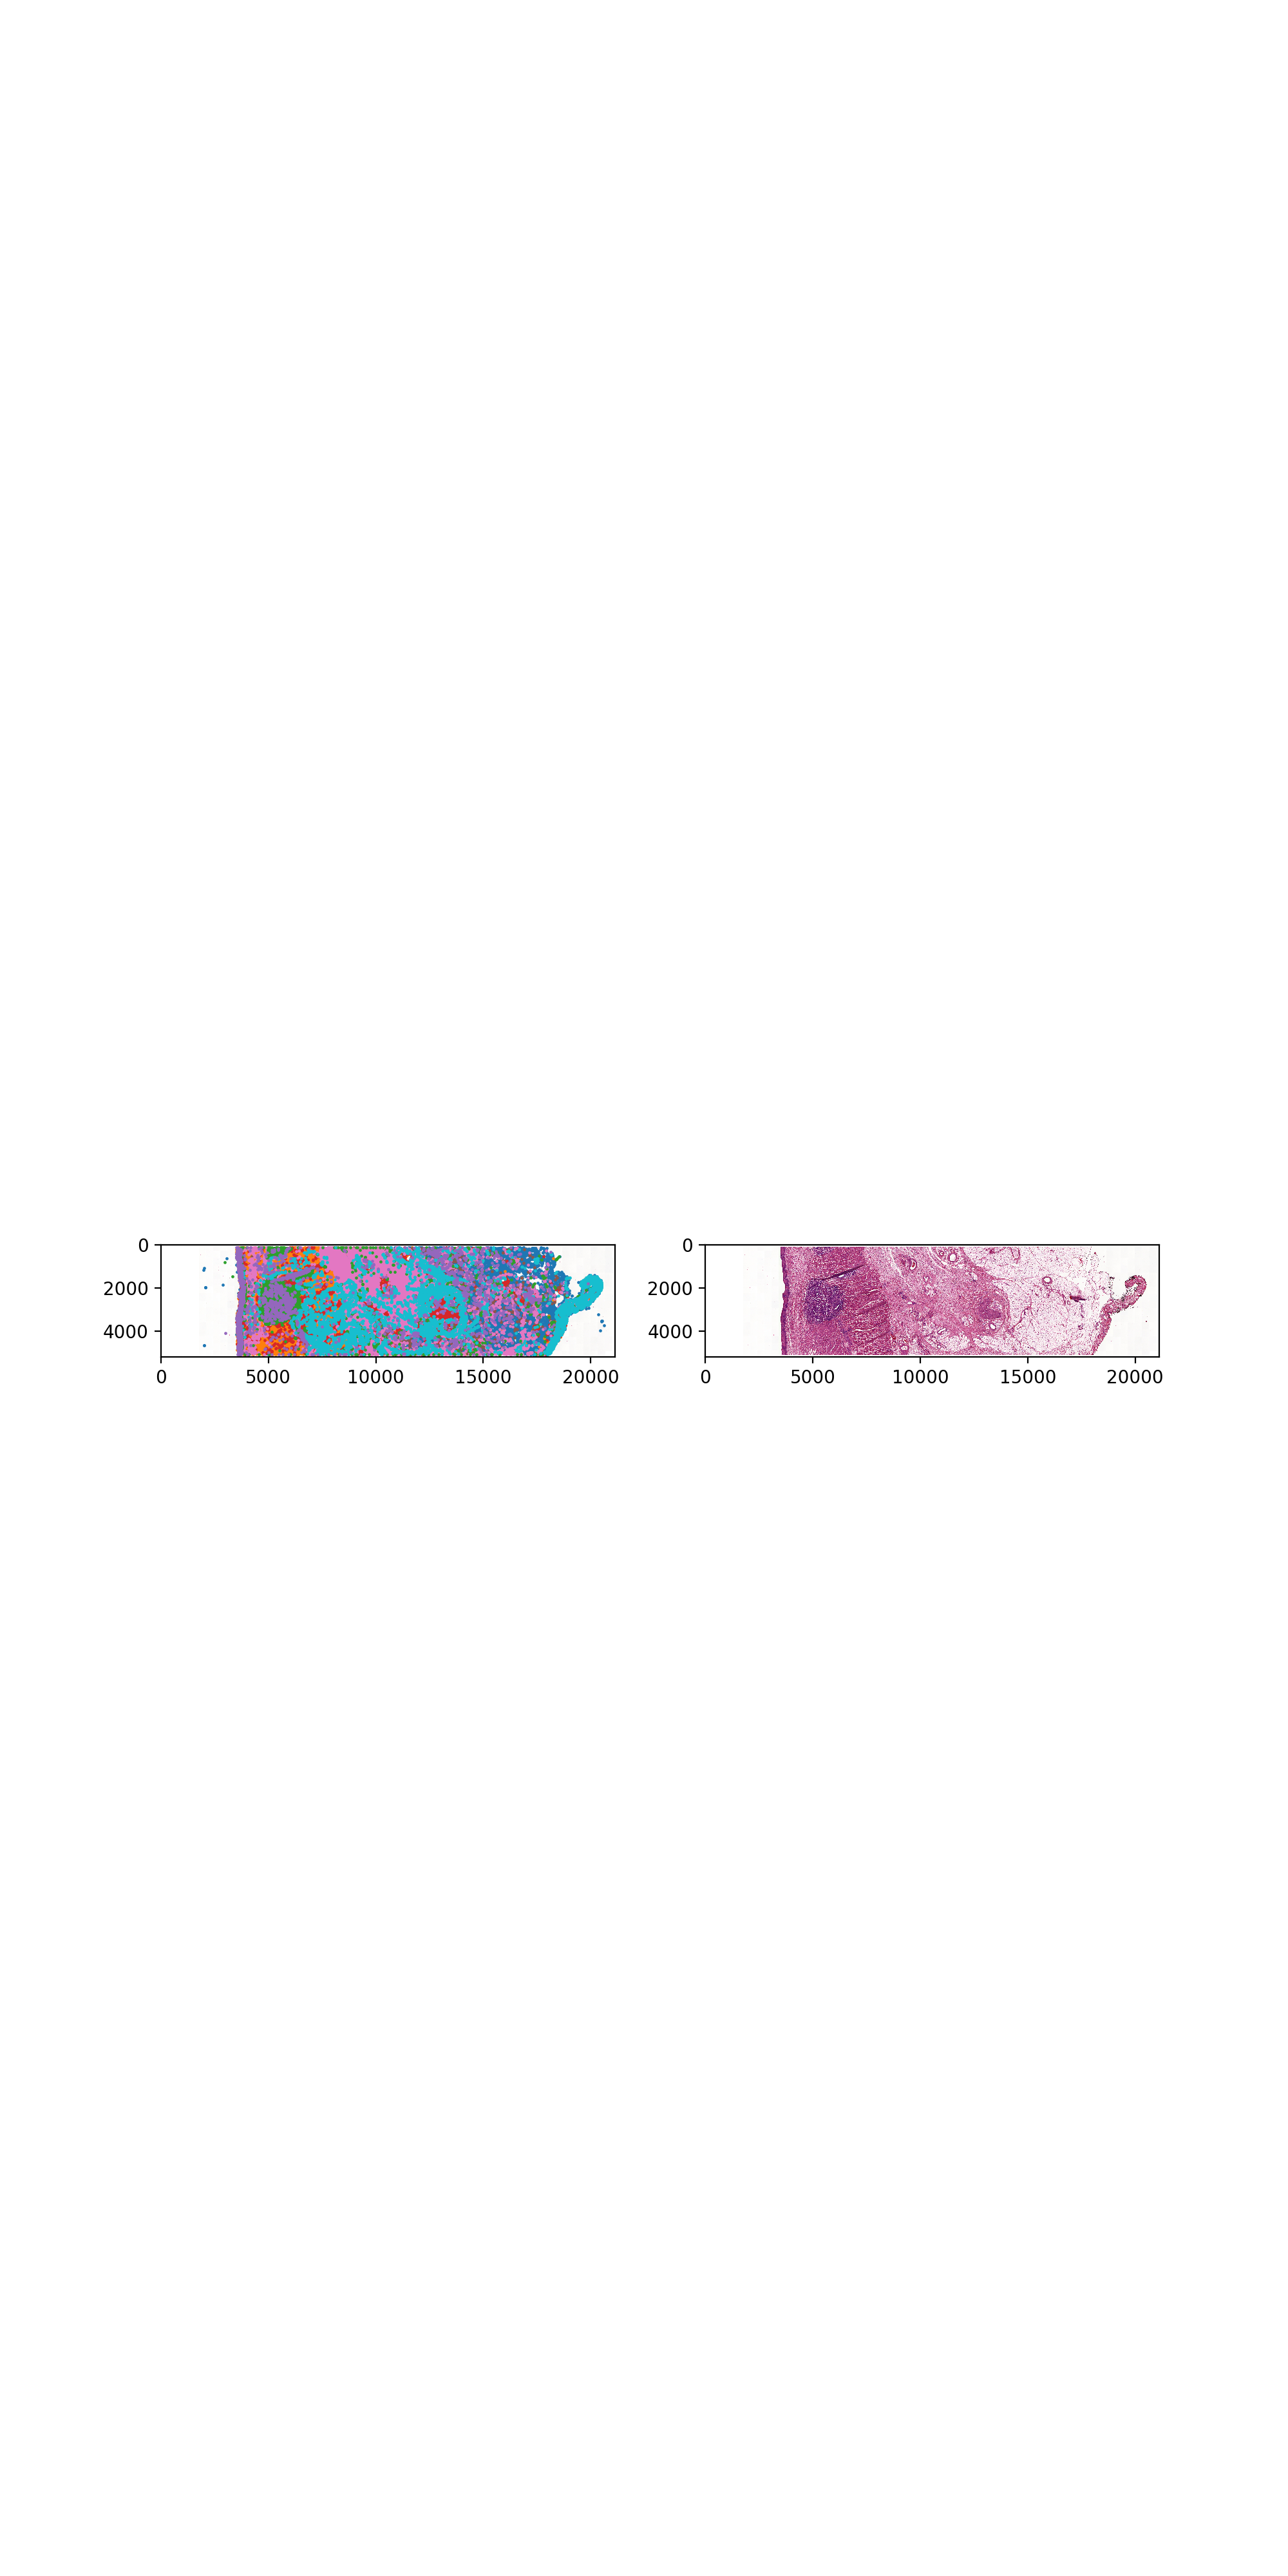

In [44]:
%matplotlib notebook
cdict = ['tab:blue','tab:orange','tab:red','tab:brown','tab:pink', 'tab:green', 'tab:cyan', 'tab:purple']
plt.rcParams["figure.figsize"] = [10, 20]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(img)
for i in range(len(class_names)):
    c = [cs[j] for j in range(len(centers)) if clusterids[j]==i]
    r = [rs[j] for j in range(len(centers)) if clusterids[j]==i]
    cl = [x for x in clusterids if x == i]  
    scatter = ax1.scatter(c, r, c=cdict[i], label = class_names[i], s=0.5)

# produce a legend with the unique colors from the scatter
#legend1 = ax1.legend(loc="upper center", ncol=3, fancybox=False)
#ax1.add_artist(legend1)

plt.show()


In [26]:
fig.savefig('out-'+ fname, bbox_inches='tight', dpi=1000)

In [ ]:
class_names

# Generate output for all the images in the folder


In [ ]:
plt.rcParams["figure.figsize"] = [10, 20]
fig, ax = plt.subplots()
ax.imshow(img)

In [ ]:
%matplolib inline
clusterids = list(clusterids)
clusterids 
c = [cs[j] for j in range(len(centers)) if clusterids[j]==1]
r = [rs[j] for j in range(len(centers)) if clusterids[j]==1]
cl = [cl for cl in clusterids if cl==1]
#plot the points
ax.scatter(c, r, c = 'red', label = 1, s = 1)
#create legend
ax.legend() 
plt.show()

In [ ]:
#plot the image
    plt.rcParams["figure.figsize"] = [10, 20]
    fig, ax = plt.subplots()
    ax.imshow(img)
    clusterids = list(clusterids)
    for i in range(len(class_names)): 
        c = [cs[j] for j in range(len(centers)) if clusterids[j]==i]
        r = [rs[j] for j in range(len(centers)) if clusterids[j]==i]
        cl = [cl for cl in clusterids if cl==i]
        #plot the points
        ax.scatter(c, r, label=class_names[i], c=i, s=1)
        #create legend
    ax.legend() 
    
    fig.savefig('out-'+ fname, bbox_inches='tight')